<a href="https://colab.research.google.com/github/al-alamin/ENSF619.2_ImageAnalysis/blob/main/Assignment_04/ENSF619_Assignment_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial on GAN**
## **Chapter 4: Generative Adversarial Networks**

## **Introduction**

This notebook contains hands-on tutorial on GAN with necessary theoretical concepts.

With the help of this tutorial, one will:
1. have basic understanding of GAN
2. have working knowledge to define, train, and apply GAN
3. learn about some problems of basic GAN model
4. know about 2 variations of GAN (i.e., WGAN & WGAN-GP) that solve some of the problems

**Reference Book:** *Generative Deep Learning* by David Foster

## **Setting up Environment**

Before starting, let's setup the environment for the whole tutorial by cloning the corresponding github repo and installing dependencies.

### **Cloning GitHub Repo**

In [ ]:
# Cloning GitHub Repo
!git clone https://github.com/JunaedYounusKhan51/GDL_code.git

Cloning into 'GDL_code'...
remote: Enumerating objects: 469, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 469 (delta 17), reused 0 (delta 0), pack-reused 413
Receiving objects: 100% (469/469), 24.15 MiB | 11.27 MiB/s, done.
Resolving deltas: 100% (254/254), done.


### **Installing Dependencies**

In [ ]:
# install packages requirements
!pip install -r /content/GDL_code/requirements.txt
!pip install keras

## **GAN**

Generative Adversarial Networks (GAN) are a clever way of training a generative model so that it can learn to generate realistic images (data) effectively. It works with two sub-models:

1.   **The Generator:** trained to generate new examples
2.   **The Discriminator:** tries to classify examples as either real (from the domain) or fake (generated)

  
So basically it is a battle between these 2 sub-models: the generator tries to fool the discriminator and the discriminator tries to detect generator's forgeries. **If you want to jump into hands-on experience of using GAN right now, you can go to 'Working with GAN' section directly from here.**     

**So you decided to learn more, Great! Let's continue:**
At the start of the process, the generator outputs noisy images and the discriminator predicts randomly. The key to GANs lies in how we alternate the training of the two networks, so that as the generator becomes more adept at fooling the discriminator, the discriminator must adapt in order to maintain its ability to correctly identify which observations are fake. This drives the generator to find new ways to fool the discriminator, and so the cycle continues.

### **The Discriminator**

The goal of the discriminator is to predict if an image is real or fake. This is a supervised image classification problem, so we can use stacked convolutional layers, followed by a dense output layer.

**The following code snippets show the step-by-step implementation of the discriminator part.** The full code can be found on https://github.com/JunaedYounusKhan51/GDL_code/blob/master/models/GAN.py 


1. Define the input to the discriminator (the image).
```
discriminator_input = Input(shape=self.input_dim, name='discriminator_input')
x = discriminator_input
```

2. Stack convolutional layers on top of each other
```
for i in range(self.n_layers_discriminator):

    x = Conv2D(
        filters = self.discriminator_conv_filters[i]
        , kernel_size = self.discriminator_conv_kernel_size[i]
        , strides = self.discriminator_conv_strides[i]
        , padding = 'same'
        , name = 'discriminator_conv_' + str(i)
        )(x)

    if self.discriminator_batch_norm_momentum and i > 0:
        x = BatchNormalization(momentum = self.discriminator_batch_norm_momentum)(x)

    x = Activation(self.discriminator_activation)(x)

    if self.discriminator_dropout_rate:
        x = Dropout(rate = self.discriminator_dropout_rate)(x)
```

3. Flatten the last convolutional layer to a vector.
```
x = Flatten()(x)
```

4. Dense layer of one unit, with a sigmoid activation function that transforms the output from the dense layer to the range [0, 1].
```
discriminator_output= Dense(1, activation='sigmoid'
    , kernel_initializer = self.weight_init)(x)
```

5. The Keras model that defines the discriminator—a model that takes an input image and outputs a single number between 0 and 1.
```
discriminator = Model(discriminator_input, discriminator_output)
```





### **The Generator**

The input to the generator is a vector, usually drawn from a multivariate standard normal distribution. The output is an image of the same size as an image in the original training data.

If you are thinking it fulfills exactly the same purpose as the decoder of a Variational Auto Encoder, you are 100% right. It converts a vector in the latent space to an image.


**The following code snippets show the step-by-step implementation of the generator part.** The full code can be found on https://github.com/JunaedYounusKhan51/GDL_code/blob/master/models/GAN.py 


1. Define the input to the generator.
```
generator_input = Input(shape=(self.z_dim,), name='generator_input')
x = generator_input
```

2. We follow this with a Dense layer.
```
x = Dense(np.prod(self.generator_initial_dense_layer_size))(x)
if self.generator_batch_norm_momentum:
    x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)
x = Activation(self.generator_activation)(x)
```

3. After applying batch normalization and a ReLU activation function.
```
x = Reshape(self.generator_initial_dense_layer_size)(x)
if self.generator_dropout_rate:
    x = Dropout(rate = self.generator_dropout_rate)(x)
```

4. We pass this through four Conv2D layers, the first two preceded by Upsampling2D layers, to reshape the tensor to the original image size. In all but the last layer, we use batch normalization and ReLU activation (LeakyReLU could also be used).
```
for i in range(self.n_layers_generator):

    x = UpSampling2D()(x)
    x = Conv2D(
        filters = self.generator_conv_filters[i]
        , kernel_size = self.generator_conv_kernel_size[i]
        , padding = 'same'
        , name = 'generator_conv_' + str(i)
        )(x)
```

5. After the final Conv2D layer, we use a tanh activation to transform the output to the range [–1, 1], to match the original image domain.
```
    if i < n_layers_generator - 1:
        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum = self.generator_batch_norm_momentum))(x)
        x = Activation('relu')(x)
    else:
        x = Activation('tanh')(x)
generator_output = x
```

6. The Keras model that defines the generator—a model that accepts a vector and outputs a tensor.
```
generator = Model(generator_input, generator_output)
```





### **Training Process**

**Training the Discriminator:**
We can train the discriminator by creating a training set where some of the images are randomly selected real observations from the training set and some are outputs from the generator. The response would be 1 for the true images and 0 for the generated images. 

**The following code snippet shows the implementation of training the discriminator.** The full code can be found on https://github.com/JunaedYounusKhan51/GDL_code/blob/master/models/GAN.py

```
def train_discriminator(x_train, batch_size):
    valid = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    # TRAIN ON REAL IMAGES
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    true_imgs = x_train[idx]
    self.discriminator.train_on_batch(true_imgs, valid)

    # TRAIN ON GENERATED IMAGES
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(noise)
    self.discriminator.train_on_batch(gen_imgs, fake)
```



**Training the Generator:**
To train the generator, we must first connect it to the discriminator to create a Keras model that we can train. Specifically, we feed the output from the generator (a 28 × 28 × 1 image) into the discriminator so that the output from this combined model is the probability that the generated image is real, according to the discriminator. 

**The following code snippet shows the implementation of training the generator.** The full code can be found on https://github.com/JunaedYounusKhan51/GDL_code/blob/master/models/GAN.py

```
def train_generator(batch_size):
    valid = np.ones((batch_size,1))
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    self.model.train_on_batch(noise, valid)
```


A diagram of the training process for the discriminator and generator is shown below:

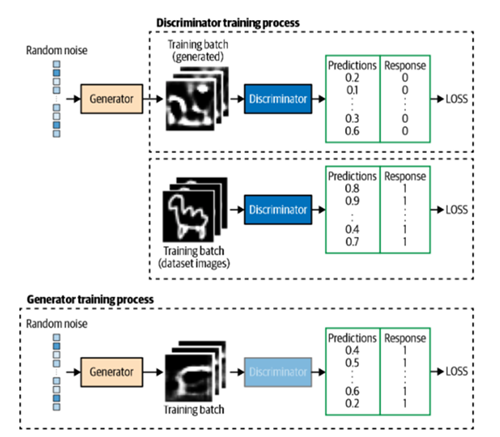

### **Working with GAN**

Here comes the interesting part: **hands-on experience of GAN**. We will build our first GAN in Keras to generate pictures.

#### **Importing necessary libs**

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np


#importing GDL libraries
from GDL_code.models.GAN import GAN
from GDL_code.utils.loaders import load_safari

Using TensorFlow backend.


#### **Dataset**

For GAN, we’ll be using the Quick, Draw! dataset from Google. This is a crowdsourced collection of 28 × 28–pixel grayscale doodles, labeled by subject. The dataset was collected as part of an online game that challenged players to draw a picture of an object or concept, while a neural network tries to guess the subject of the doodle.


**Download Dataset:**
Let's download the dataset to '/content/GDL_code/data/camel' directory. The following code will do that for you:



In [ ]:
#making directory for keeping the dataset and downloading the dataset from source to that directory
os.mkdir("/content/GDL_code/data/camel")
!wget -P /content/GDL_code/data/camel https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/camel.npy

--2021-12-02 07:37:20--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/camel.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95176896 (91M) [application/octet-stream]
Saving to: ‘/content/GDL_code/data/camel/camel.npy’

camel.npy             0%[                    ]       0  --.-KB/s               ^C


**Let's define some environment variables and create the folders for saving model, generated samples, etc with given names.**


In [ ]:
# run params
SECTION = 'gan'
RUN_ID = '0001'
DATA_NAME = 'camel'
RUN_FOLDER = '/content/GDL_code/run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))



**Load the downloaded dataset with pre-defined function**

In [ ]:
#loading dataset for training model
(x_train, y_train) = load_safari(DATA_NAME)

**Data Exploration**

We can see there are 80000 data where each image is of size 28X28. We can also see an example of the images.

In [ ]:
print(x_train.shape)
plt.imshow(x_train[205,:,:,0], cmap = 'gray')

#### **Defining Your GAN Model**

You can define a GAN model using the following code. Except 'z_dim' which means the input vector length for the generator, all the other parameter names are self-explanatory.

Note that the input dimension is given (28, 28, 1) as per the size of the original images of our dataset.

By **mode**, we will decide whether we are building a new model or loading a trained model for future use. 

In [ ]:
# defining GAN model with necessary parameters
gan = GAN(input_dim = (28,28,1)
        , discriminator_conv_filters = [64,64,128,128]
        , discriminator_conv_kernel_size = [5,5,5,5]
        , discriminator_conv_strides = [2,2,2,1]
        , discriminator_batch_norm_momentum = None
        , discriminator_activation = 'relu'
        , discriminator_dropout_rate = 0.4
        , discriminator_learning_rate = 0.0008
        , generator_initial_dense_layer_size = (7, 7, 64)
        , generator_upsample = [2,2, 1, 1]
        , generator_conv_filters = [128,64, 64,1]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [1,1, 1, 1]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0004
        , optimiser = 'rmsprop'
        , z_dim = 100
        )

# we want to build the model
mode =  'build' #'load'

if mode == 'build':
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5')) #for load option, using the previously saved model

**Summary of our Discriminator:** We can see the discriminator summary using the following command.





In [ ]:
print(gan.discriminator.summary())

**Summary of our Generator:** We can see the generator summary using the following command.

In [ ]:
print(gan.generator.summary())

#### **Training Your GAN**

Now that our model is defined, we can proceed to training it. 

**First, define some training parameters.** Note that we are using just 10 epochs here for time-constraint. **To evaluate the actual ability of the GAN model and get good results, please train it for more number of epochs (e.g., 6000).** 

In [ ]:
BATCH_SIZE = 64
EPOCHS = 10 #6000
PRINT_EVERY_N_BATCHES = 5

**Let's start training using the following code.** This will internally use the train_discriminator and train_genarator function discussed in the previous section.

In [ ]:
# training the GAN model 
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
)

**Loss and Accuracy Graph:** We can see the loss and accuracy graph during the training using the following codes. **Remember that the graphs would look different if we would use an appropriately high number of epochs.** 

In [ ]:
# plotting loss
fig = plt.figure()

# plotting for avg of real and fake
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25) 
# plotting for real 
plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
# plotting for fake
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
# plotting for generator
plt.plot([x[0] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)


plt.xlim(0, EPOCHS)
plt.ylim(0, 2)

plt.show()

In [ ]:
# plotting accuracy
fig = plt.figure()

# plotting for avg of real and fake
plt.plot([x[3] for x in gan.d_losses], color='black', linewidth=0.25)
# plotting for real
plt.plot([x[4] for x in gan.d_losses], color='green', linewidth=0.25)
# plotting for fake
plt.plot([x[5] for x in gan.d_losses], color='red', linewidth=0.25)
# plotting for generator
plt.plot([x[1] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, EPOCHS)

plt.show()

**Expected Loss and Accuracy Graphs:** Since in this tutorial, we have used small number of epochs to save time, we are attaching the expected loss and accuracy graph found for a appropriate/high number of epochs.

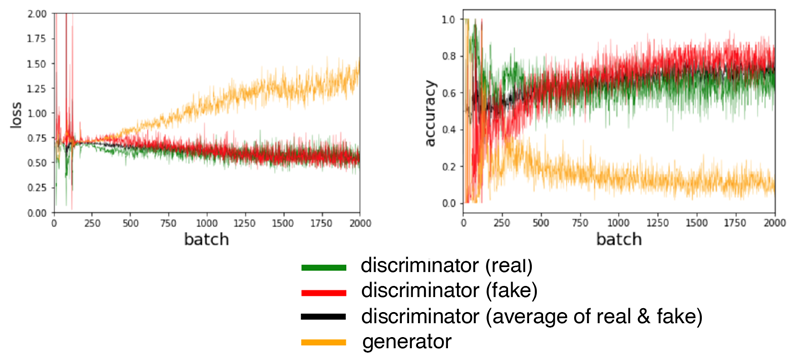

#### **Generate New Img with GAN**

Now we can use the trained model for generating new images using the following code. We can see how GAN generates data from a given noise.

Since we used small number of epochs, the output is not quite fascinating. With higher number of epochs, the output quality would be better.

In [ ]:
num_generated_img = 5

# creating noise to be input to GAN
noise = np.random.normal(0, 1, (num_generated_img, gan.z_dim))

# generating image 
gen_imgs = gan.generator.predict(noise)

plt.imshow(gen_imgs[4,:,:,0], cmap = 'gray')

**Expected Generated Samples with more Epochs:** Since we used small number of epochs, below we are showing some GAN images generated on different stage while using more epochs.

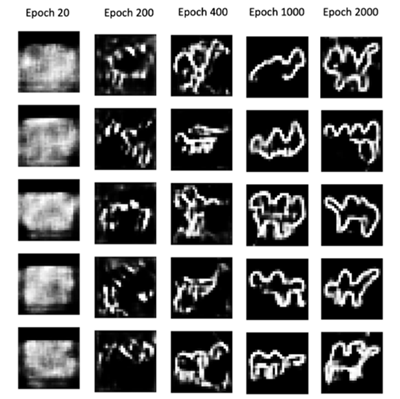

### **Issues of GAN**
1. ***Oscillating Loss:*** The loss of the discriminator and generator can start to oscillate wildly, rather than exhibiting long-term stability
2. ***Mode Collapse:*** Mode collapse occurs when the generator finds a small number of samples that fool the discriminator and therefore isn’t able to produce any examples other than this limited set. 
3. ***Uninformative Loss:*** The loss function of the generator actually increases over time, even though the quality of the images is clearly improving. This lack of correlation between the generator loss and image quality sometimes makes GAN training difficult to monitor.
4. ***Hyperparameters:*** GAN has a large number of hyperparameters to tune. 


### **Tackling the GAN Issues**

To tackle such issues, several variants of GAN have been proposed over the years. Two of them are **Wasserstein GAN (WGAN)** & **Wasserstein GAN–Gradient Penalty (WGAN-GP)**

Now we will learn some basic concepts of WGAN & WGAN-GP and see how we can use them.


## **WGAN**

The Wasserstein GAN was proposed to stabilize GAN training. It has the following two properties:

1. A meaningful loss metric that correlates with the generator’s convergence and sample quality
2. Improved stability of the optimization process


**If you want to jump into hands-on experience of using WGAN right now, you can go to 'Working with GAN' section directly from here.**



WGAN uses a new loss function (Wasserstein loss function) for both the discriminator and the generator. Using this loss function instead of binary cross entropy results in a more stable convergence of the GAN. 

### **Wasserstein Loss**
First, the Wasserstein loss requires that we use y_i=1 and y_i=-1 as labels, rather than 1 and 0. We also remove the sigmoid activation from the final layer of the discriminator, so that predictions pi are no longer constrained to fall in the range [0,1], but instead can now be any number in the range [–∞, ∞]. For this reason, the discriminator in a WGAN is usually referred to as a critic. The Wasserstein loss function is then defined as follows:

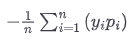

### **Lipschitz Constraint**

In WGAN, the critic can output any number in the range [–∞, ∞], rather than applying a sigmoid function to restrict the output to [0, 1] range. The Wasserstein loss can therefore be very large, which is unsettling—usually, large numbers in neural networks are to be avoided!

The Wasserstein loss function to work, an additional constraint (Lipschitz Constraint) is required on the critic. For that, the critic D has to satisfy the following inequality for any two input images, x1 and x2:

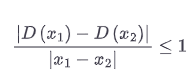



### **Weight Clipping**
It is possible to enforce the Lipschitz constraint by clipping the weights of the critic to lie within a small range, [–0.01, 0.01], after each training batch.

We can do it during the critic training as follows. The full code can be found on https://github.com/JunaedYounusKhan51/GDL_code/blob/master/models/WGAN.py 

```
def train_critic(x_train, batch_size, clip_threshold):

    valid = np.ones((batch_size,1))
    fake = -np.ones((batch_size,1))

    # TRAIN ON REAL IMAGES
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    true_imgs = x_train[idx]
    self.critic.train_on_batch(true_imgs, valid)

    # TRAIN ON GENERATED IMAGES
    noise = np.random.normal(0, 1, (batch_size, self.z_dim))
    gen_imgs = self.generator.predict(noise)
    self.critic.train_on_batch(gen_imgs, fake)

    for l in critic.layers:
        weights = l.get_weights()
        weights = [np.clip(w, -clip_threshold, clip_threshold) for w in weights]
        l.set_weights(weights)
```

### **Working with WGAN**

#### Importing necessary libs

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle

# importing GDL libraries
from GDL_code.models.WGAN import WGAN
from GDL_code.utils.loaders import load_cifar

#### **Dataset**

For WGAN, we’ll use horse images from the CIFAR-10 dataset. 



**Let's define some environment variables and create the folders for saving model, generated samples, etc with given names.**


In [ ]:
# run params
SECTION = 'gan'
RUN_ID = '0002'
DATA_NAME = 'horses'
RUN_FOLDER = '/content/GDL_code/run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))
    

**# The CIFAR-10 dataset has 10 classes. We are focusing on the horse for this example which is labeled as 7. We can experiment on other classes as well e.g., cars.**

In [ ]:
# in CIFAR-10, label of car is 1 and horse is 7
if DATA_NAME == 'cars':
    label = 1
elif DATA_NAME == 'horses':
    label = 7


**Load the CIFAR-10 dataset with pre-defined function**

In [ ]:
(x_train, y_train) = load_cifar(label, 10)

170500096/170498071 [==============================] - 3s 0us/step


**Data Exploration**

We can see there are 6000 data where each image is of size 32X32X3 (3 means color image). We can also see an example image from the dataset.

(6000, 32, 32, 3)


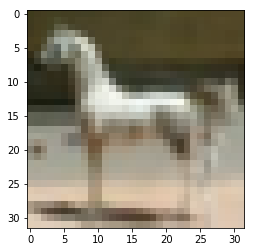

In [ ]:
print(x_train.shape)
plt.imshow((x_train[150,:,:,:]+1)/2)

#### **Defining WGAN Model**

You can define a WGAN model using the following code. The parameters are almost similar to the ones of GAN. Note that we tend to use smaller learning rates for WGANs.

In [ ]:
mode =  'build' #'load' #

if mode == 'build':

    wgan = WGAN(input_dim = (32,32,3)
            , critic_conv_filters = [32,64,128,128]
            , critic_conv_kernel_size = [5,5,5,5]
            , critic_conv_strides = [2,2,2,1]
            , critic_batch_norm_momentum = None
            , critic_activation = 'leaky_relu'
            , critic_dropout_rate = None
            , critic_learning_rate = 0.00005
            , generator_initial_dense_layer_size = (4, 4, 128)
            , generator_upsample = [2,2, 2,1]
            , generator_conv_filters = [128,64,32,3]
            , generator_conv_kernel_size = [5,5,5,5]
            , generator_conv_strides = [1,1, 1,1]
            , generator_batch_norm_momentum = 0.8
            , generator_activation = 'leaky_relu'
            , generator_dropout_rate = None
            , generator_learning_rate = 0.00005
            , optimiser = 'rmsprop'
            , z_dim = 100
            )
    wgan.save(RUN_FOLDER)

else:
    wgan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

W1202 07:39:26.812885 140417198876544 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1202 07:39:26.832576 140417198876544 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W1202 07:39:26.850453 140417198876544 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1202 07:39:26.997351 140417198876544 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1202 07:39:27.137190 14

**Summary of our Critic:** We can see the critic summary using the following command.

In [ ]:
wgan.critic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
critic_conv_0 (Conv2D)       (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
critic_conv_1 (Conv2D)       (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
critic_conv_2 (Conv2D)       (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 128)         0         
__________

**Summary of our Generator:** We can see the generator summary using the following command.

In [ ]:
wgan.generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 128)         0         
_________________________________________________________________
generator_conv_0 (Conv2D)    (None, 8, 8, 128)         409728    
__________

#### **Training WGAN**


Now that our model is defined, we can proceed to training it. 

**First, define some training parameters.** Note that we are using just 10 epochs here for time-constraint. **To evaluate the actual ability of the model and get good results, please train it for more number of epochs (e.g., 6000).** 

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10 #6000
PRINT_EVERY_N_BATCHES = 5
N_CRITIC = 5 #number of critics
CLIP_THRESHOLD = 0.01 # threshold where we want to clip

**Let's start training using the following code.** 

In [ ]:
wgan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , clip_threshold = CLIP_THRESHOLD
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10 [D loss: (0.000)(R -0.028, F 0.029)]  [G loss: -0.009] 


**Loss and Accuracy Graph:** We can see the loss and accuracy graph during the training using the following codes. **Remember that the graphs might look different if we would use an appropriately high number of epochs.** 

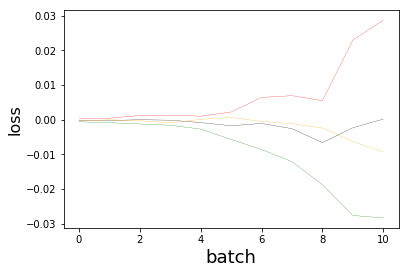

In [ ]:
fig = plt.figure()

# plotting for avg of real and fake
plt.plot([x[0] for x in wgan.d_losses], color='black', linewidth=0.25)
# plotting for real 
plt.plot([x[1] for x in wgan.d_losses], color='green', linewidth=0.25)
# plotting for fake
plt.plot([x[2] for x in wgan.d_losses], color='red', linewidth=0.25)
# plotting for generator
plt.plot(wgan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)



plt.show()

#### **Generate New Img with WGAN**

Now we can use the trained model for generating new images using the following codes.

Since we used small number of epochs, the output is not quite fascinating. With higher number of epochs, the output quality would be better.



In [ ]:
#wgan.sample_images(RUN_FOLDER)

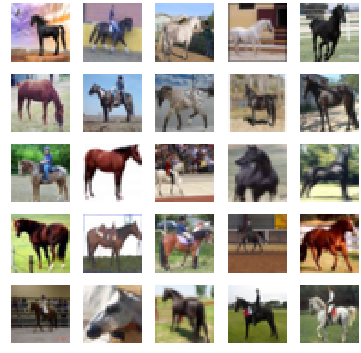

In [ ]:
'''r, c = 5, 5

idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
true_imgs = (x_train[idx] + 1) *0.5

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(true_imgs[cnt], cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/real.png"))

fig.set_dpi(30)
plt.show() 
plt.close()'''

WGAN Generated Images:
-----------------------


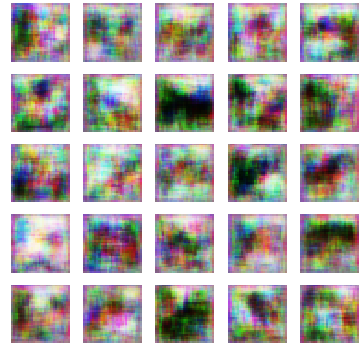

In [ ]:
r, c = 5, 5 # number of row (r) and column (c) we want to show our image in. So total number of images = r * c

# creating noise to be input in GAN
noise = np.random.normal(0, 1, (r * c, wgan.z_dim))

# generating new images
gen_imgs = wgan.generator.predict(noise)

#Rescale images 0 - 1
gen_imgs = 0.5 * (gen_imgs + 1)
#gen_imgs = np.clip(gen_imgs, 0, 1)

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/sample.png"))

print("WGAN Generated Images:")
print("-----------------------")
fig.set_dpi(30)
plt.show() 
plt.close()





**Closest Real Images:** Now, using the following codes, we can find the real images from the train set that are closest (i.e., most similar) to generated ones so that we can do any necessary comparison. 

To find the closest image, we need to compare two image. For that we will use the following *compare_images(img1, img2)* function.


In [ ]:
'''
method for comparing two images. 
Input: two images
Returns: their difference 
'''
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

Real images from train-set that are closest to the generated ones:
-------------------------------------------------------------------


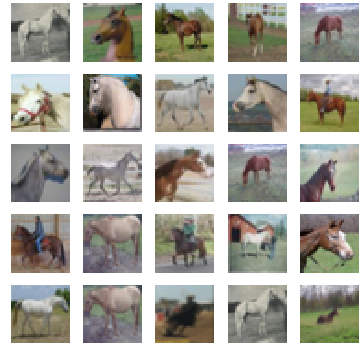

In [ ]:
fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate((x_train + 1) * 0.5):
            
            diff = compare_images(gen_imgs[cnt, :,:,:], k) # comparing the real and generated image
            if diff < c_diff: # taking the one with least difference so far
                c_img = np.copy(k)
                c_diff = diff
        axs[i,j].imshow(c_img, cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1

fig.savefig(os.path.join(RUN_FOLDER, "images/sample_closest.png"))

print("Real images from train-set that are closest to the generated ones:")
print("-------------------------------------------------------------------")
fig.set_dpi(30)
plt.show() 
plt.close()

**Expected Generated Samples with more Epochs:** Since we used small number of epochs, below we are showing some WGAN images generated using more epochs (i.e., 6000).


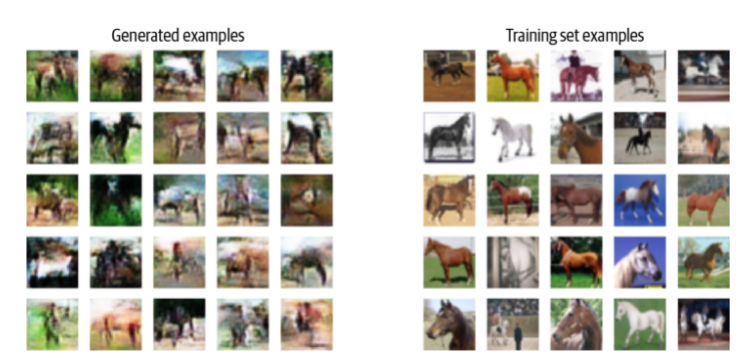

### **Issues with WGAN**

The main criticism of the WGAN is that since we are clipping the weights in the critic, its capacity to learn is greatly diminished. In fact, even in the original WGAN paper the authors write, “Weight clipping is a clearly terrible way to enforce a Lipschitz constraint.”

## **WGAN-GP**

One of the most recent extensions to the WGAN literature is the Wasserstein GAN–Gradient Penalty (WGAN-GP) framework.

We can convert our WGAN critic to a WGAN-GP critic by the following 3 changes:

1. Include a gradient penalty term in the critic loss function.
2. Avoid clipping the weights of the critic.
3. Remove batch normalization layers in the critic.

###**Gradient Penalty Loss**

The gradient penalty loss measures the squared difference between the norm of the gradient of the predictions with respect to the input images and 1. The model will naturally be inclined to find weights that ensure the gradient penalty term is minimized, thereby encouraging the model to conform to the Lipschitz constraint.

The implementation of gradient penalty loss is as below.
```
def gradient_penalty_loss(y_true, y_pred, interpolated_samples):

    gradients = K.gradients(y_pred, interpolated_samples)[0] 1

    gradient_l2_norm = K.sqrt(
        K.sum(
            K.square(gradients),
            axis=[1:len(gradients.shape)]
            )
        )
    ) 2
    gradient_penalty = K.square(1 - gradient_l2_norm)
    return K.mean(gradient_penalty) 3
```

### **Working with WGAN-GP**

#### Importing necessary libs

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle

#importing GDL libraries
from GDL_code.models.WGANGP import WGANGP
from GDL_code.utils.loaders import load_celeb

Using TensorFlow backend.


#### **Dataset**

For WGAN-GP, we’ll use celeb dataset. Since the dataset size is large (202599), we will work on a small subset of just 20 samples for this tutorial. To work on the whole dataset, please put all the images in the '/content/data/celeb/img_align_celeba/' directory.

The celeb dataset can be found on the Kaggle at this link: https://www.kaggle.com/jessicali9530/celeba-dataset



**Let's define some environment variables and create the folders for saving model, generated samples, etc with given names.**


In [ ]:
# run params
SECTION = 'gan'
RUN_ID = '0003'
DATA_NAME = 'celeb'
RUN_FOLDER = '/content/GDL_code/run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))


# defining batch and image size
BATCH_SIZE = 16
IMAGE_SIZE = 64

**Load the dataset with pre-defined function**

In [ ]:
x_train = load_celeb(DATA_NAME, IMAGE_SIZE, BATCH_SIZE)

Found 20 images belonging to 1 classes.


**Data Exploration**

Here we can see example image from the dataset.

In [ ]:
plt.imshow((x_train[0][0][0]+1)/2)
print(x_train[0][0][0])

[[[ 0.8117647   0.24705882 -0.12941177]
  [ 0.8901961   0.3019608  -0.14509805]
  [ 0.92941177  0.33333334 -0.15294118]
  ...
  [-0.39607844 -0.4509804  -0.5764706 ]
  [-0.39607844 -0.4509804  -0.5764706 ]
  [-0.39607844 -0.4509804  -0.5764706 ]]

 [[ 0.79607844  0.23137255 -0.14509805]
  [ 0.88235295  0.29411766 -0.13725491]
  [ 0.92156863  0.3254902  -0.14509805]
  ...
  [-0.39607844 -0.4509804  -0.5764706 ]
  [-0.39607844 -0.4509804  -0.5764706 ]
  [-0.39607844 -0.4509804  -0.5764706 ]]

 [[ 0.79607844  0.22352941 -0.12941177]
  [ 0.88235295  0.28627452 -0.12156863]
  [ 0.92156863  0.3254902  -0.14509805]
  ...
  [-0.39607844 -0.4509804  -0.5764706 ]
  [-0.39607844 -0.4509804  -0.5764706 ]
  [-0.39607844 -0.4509804  -0.5764706 ]]

 ...

 [[ 0.07450981 -0.4745098  -0.75686276]
  [ 0.12941177 -0.41960785 -0.7019608 ]
  [ 0.16862746 -0.37254903 -0.6784314 ]
  ...
  [-0.75686276 -0.73333335 -0.8666667 ]
  [-0.75686276 -0.7490196  -0.85882354]
  [-0.7490196  -0.7647059  -0.85882354]]

 [

#### **Defining WGAN-GP Model**

You can define a WGAN-GP model using the following code. The parameters are almost similar to the ones of GAN or WGAN. 

In [ ]:
wgan_gp = WGANGP(input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
        , critic_conv_filters = [64,128,256,512]
        , critic_conv_kernel_size = [5,5,5,5]
        , critic_conv_strides = [2,2,2,2]
        , critic_batch_norm_momentum = None
        , critic_activation = 'leaky_relu'
        , critic_dropout_rate = None
        , critic_learning_rate = 0.0002
        , generator_initial_dense_layer_size = (4, 4, 512)
        , generator_upsample = [1,1,1,1]
        , generator_conv_filters = [256,128,64,3]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [2,2,2,2]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0002
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 100
        , batch_size = BATCH_SIZE
        )

mode =  'build' #'load' #

if mode == 'build':
    wgan_gp.save(RUN_FOLDER)

else:
    wgan_gp.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))




**Summary of our Critic:** We can see the critic summary using the following command.

In [ ]:
wgan_gp.critic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    (None, 64, 64, 3)         0         
_________________________________________________________________
critic_conv_0 (Conv2D)       (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
critic_conv_1 (Conv2D)       (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
critic_conv_2 (Conv2D)       (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 256)         0         
__________

**Summary of our Generator:** We can see the generator summary using the following command.

In [ ]:
wgan_gp.generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
generator_conv_0 (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)         1024      
__________

#### **Training WGAN-GP**


Now that our model is defined, we can proceed to training it. 

**First, define some training parameters.** Note that we are using just 30 epochs here for time-constraint. **To evaluate the actual ability of the model and get good results, please train it for more number of epochs (e.g., 6000).**

In [ ]:
EPOCHS = 30 #6000
PRINT_EVERY_N_BATCHES = 5
N_CRITIC = 1 #5
#BATCH_SIZE = 4 #64

**Let's start training using the following code.** 

In [ ]:
# training WGAN-GP model
wgan_gp.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , using_generator = True
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
W1202 08:43:15.784025 140511775582080 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 (5, 1) [D loss: (0.1)(R -3.8, F -1.7, G 0.6)] [G loss: 3.4]


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 (1, 1) [D loss: (-6.5)(R -8.1, F -1.8, G 0.3)] [G loss: 4.0]
2 (1, 1) [D loss: (-15.1)(R -15.4, F -0.3, G 0.1)] [G loss: 3.7]
3 (1, 1) [D loss: (-24.7)(R -28.5, F 3.4, G 0.0)] [G loss: 1.5]
4 (1, 1) [D loss: (-33.1)(R -48.3, F 9.4, G 0.6)] [G loss: -1.9]
5 (1, 1) [D loss: (-40.2)(R -71.7, F 14.4, G 1.7)] [G loss: -3.5]
6 (1, 1) [D loss: (-51.3)(R -84.0, F 14.0, G 1.9)] [G loss: -5.3]
7 (1, 1) [D loss: (-63.5)(R -103.6, F 15.1, G 2.5)] [G loss: -11.3]
8 (1, 1) [D loss: (-54.2)(R -110.8, F 23.7, G 3.3)] [G loss: -14.2]
9 (1, 1) [D loss: (-60.5)(R -110.9, F 26.6, G 2.4)] [G loss: -23.2]
10 (1, 1) [D loss: (-54.8)(R -113.8, F 36.8, G 2.2)] [G loss: -24.5]
11 (1, 1) [D loss: (-59.9)(R -111.4, F 36.5, G 1.5)] [G loss: -20.7]
12 (1, 1) [D loss: (-62.8)(R -116.0, F 30.3, G 2.3)] [G loss: -1.6]
13 (1, 1) [D loss: (-77.9)(R -105.9, F 7.8, G 2.0)] [G loss: -5.3]
14 (1, 1) [D loss: (-76.3)(R -122.9, F 10.9, G 3.6)] [G loss: 3.7]
15 (1, 1) [D loss: (-82.7)(R -133.6, F 1.9, G 4.9)] [G loss: 13.3]


**Loss and Accuracy Graph:** We can see the loss and accuracy graph during the training using the following codes. **Remember that the graphs might look different if we would use an appropriately high number of epochs.** 

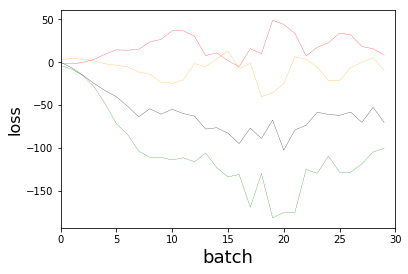

In [ ]:
fig = plt.figure()

# plotting for avg of real and fake
plt.plot([x[0] for x in wgan_gp.d_losses], color='black', linewidth=0.25)
# plotting for real
plt.plot([x[1] for x in wgan_gp.d_losses], color='green', linewidth=0.25)
# plotting for fake
plt.plot([x[2] for x in wgan_gp.d_losses], color='red', linewidth=0.25)
# plotting for generator
plt.plot(wgan_gp.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, EPOCHS)
# plt.ylim(0, 2)

plt.show()


#### **Generate New Img with WGAN-GP**

Now we can use the trained model for generating new images using the following codes.

Since we used small number of epochs, the output is not fascinating (not even close). With higher number of epochs, the output quality would be better.

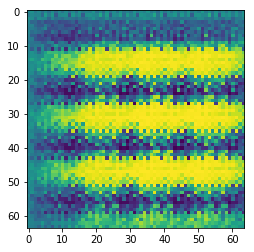

In [ ]:
num_generated_img = 1
# creating noise to be input to model
noise = np.random.normal(0, 1, (num_generated_img, wgan_gp.z_dim))
# generating new images
gen_imgs = wgan_gp.generator.predict(noise)
plt.imshow(gen_imgs[0,:,:,0])

**Expected Generated Samples with more Epochs:** Since we used small number of epochs, below we are showing some WGAN-GP images generated using more epochs (i.e., 6000).


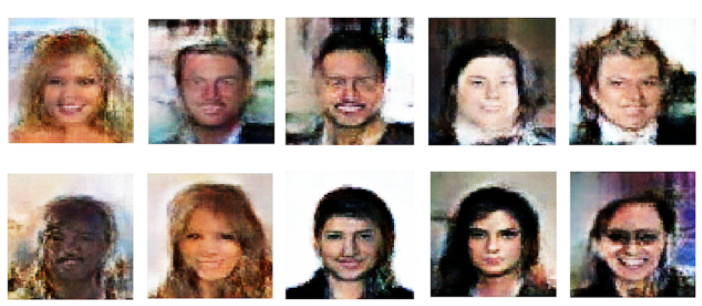

## **Summary**

In this tutorial, we have explored three distinct flavors of GAN. They are:
  1. GAN (vanilla)
  2. WGAN (Wasserstein)
  3. WGAN-GP (W. Gradient Penalty)

We now have basic understanding about how such models work and practical knowledge how to use them. 